In [57]:
import mvpa2.suite as mv
import os.path as op
import datalad.api as dl
from datalad.auto import AutomagicIO

In [2]:
toppath = op.pardir
imgspath = op.join(toppath, 'derivatives/plotting/nifti_imgs')

sub = 20
brain_mask = op.join(toppath, 'sub-%02d/ses-movie/anat/brain_mask_tmpl.nii.gz' % sub)

In [43]:
# ROI
ROI = 'FFA'
mask_files = {
    '%s%s' % (lr, ROI): op.join(toppath, 'sub-%2d/ses-movie/anat/%s%s_%d_mask_tmpl.nii.gz' % (sub, lr, ROI, ilr+1))
    for ilr, lr in enumerate('rl')
}

In [126]:
from collections import OrderedDict
plots = OrderedDict()
experiments_styles = [('localizer', {'lw': 1}), ('avmovie', {'lw': 1})]
for exp, style in experiments_styles:
    style = style.copy()
    plots['%s_canonical-contrast' % exp] = dict(style, **{'color': 'orange', 'linestyle': ':'})
    # To be gone probably
    plots['%s_informed-contrast' % exp] = dict(style, **{'color': 'orange', 'linestyle': '-', 'lw': 2})
    plots['%s_estimates_allROIs' % exp] = dict(style, **{'color': 'navy', 'linestyle': '-', 'lw': 2})
    plots['%s_estimates_FFAbrain' % exp] = dict(style, **{'color': 'navy', 'linestyle': '-'})

In [127]:
# Use DataLad to fetch any file needed if not present locally
with AutomagicIO():
    ds = mv.fmri_dataset(
        [ op.join(imgspath, 'sub-%02d_%s.nii.gz' % (sub, p))
          for p in plots
        ],
        mask=brain_mask,
        targets=list(plots),
        add_fa=mask_files
    )
# eh -- hardcoding ROI for now ;)
ds.fa[ROI] = ds.fa.lFFA + ds.fa.rFFA

In [128]:
# PyMVPA broke -- no time to investigate ATM
if False:
    ##### sets here is Targets/Predictions/Estimates
    roc = mv.ROCCurve(
        [False, True],
        sets=[(ds.fa[ROI].value.astype(bool), ds.samples[0].astype(bool), ds.samples[0])]
    )
    roc.plot()

In [130]:
# via sklearn and pylab directly
# First get all those ROC curves and AUC estimates
from sklearn.metrics import roc_curve, auc
import numpy as np
fpr, tpr, roc_auc = {}, {}, {}
for i, t in enumerate(ds.targets):
    fpr[t], tpr[t], _ = roc_curve(
        ds.fa[ROI].value, # .astype(bool),
        # sanity check for perfect ds.fa[ROI].value.astype(bool)
        ds.samples[i],
        #np.zeros((ds.nfeatures,)),
        pos_label=1
    ) # y_test[:, i], y_score[:, i])
    roc_auc[t] = auc(fpr[t], tpr[t])

In [147]:
roc_curve([0, 0, 0, 1, 0, 0], [0, 2.3, 3, 4, 5, 6])

(array([0. , 0.2, 0.4, 0.4, 1. ]),
 array([0., 0., 0., 1., 1.]),
 array([7., 6., 5., 4., 0.]))

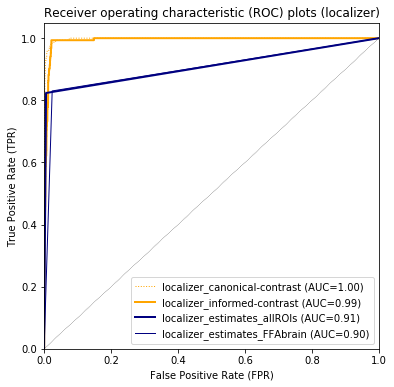

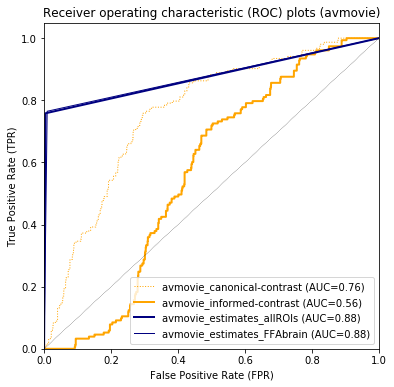

In [131]:
# Plot them up
def plot_experiment(experiment):
    import pylab as plt
    plt.figure(figsize=(6, 6))

    for t in ds.targets:
        if experiment not in t:
            continue
        #if 'canonical' not in t:
        #    continue
        style = plots[t]
        plt.plot(
            fpr[t], tpr[t],
             label='%s (AUC=%0.2f)' % (t, roc_auc[t]), **style
        )
    plt.plot([0, 1], [0, 1], color='black', lw=0.5, linestyle=':')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver operating characteristic (ROC) plots (%s)' % experiment)
    plt.legend(loc="lower right")
    plt.show()
for exp, _ in experiments_styles:
    plot_experiment(exp)